In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import time

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet import preprocess_input
import keras_cv

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


In [2]:
# Set batch size for training
BATCH_SIZE = 32

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 50

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 0.2

seed = 0

category_map = {0:0,# Background
                1:1,# Soil
                2:2,# Bedrock
                3:3,# Sand
                4:4,# Big Rock
               }

In [3]:
data = np.load("/kaggle/input/an2dl-challenge-2/mars_for_students_V1.npz")
training_set = data["training_set"]

X_train_val = training_set[:, 0]
y_train_val = training_set[:, 1]

print(X_train_val.shape)
print(y_train_val.shape)

X_test = data["test_set"]

(2505, 64, 128)
(2505, 64, 128)


In [5]:
# Split the data into training and validation
print("Splitting data...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed
)

print("Data splitted!")

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

Splitting data...
Data splitted!
(2004, 64, 128)
(2004, 64, 128)
(501, 64, 128)
(501, 64, 128)


In [6]:
# Convert the numpy arrays to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)

# Define RandAugment policy
preprocessing_pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=[
        keras_cv.layers.AutoContrast(value_range=(0,255)),
        keras_cv.layers.RandomBrightness(factor=0.5,value_range=(0,255)),
        
    ],
    augmentations_per_image=1,
    rate=1.0,
    auto_vectorize=False,
    seed=None,
)

# Augmentation function
def augment_data(image, label):
    # Apply RandAugment to the image
    image = tf.expand_dims(image, axis=-1)  # Add channel dimension if missing
    image = preprocessing_pipeline(image)
    return image, label


# Apply data augmentation
augmented_train_dataset = (
    train_dataset
    .shuffle(BATCH_SIZE)
    .map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)  # Perform augmentation
    .batch(BATCH_SIZE)  # Adjust batch size as needed
    .prefetch(tf.data.AUTOTUNE)  # Prefetch for efficiency
)

Batch images shape: (32, 64, 128)
Batch labels shape: (32, 64, 128)


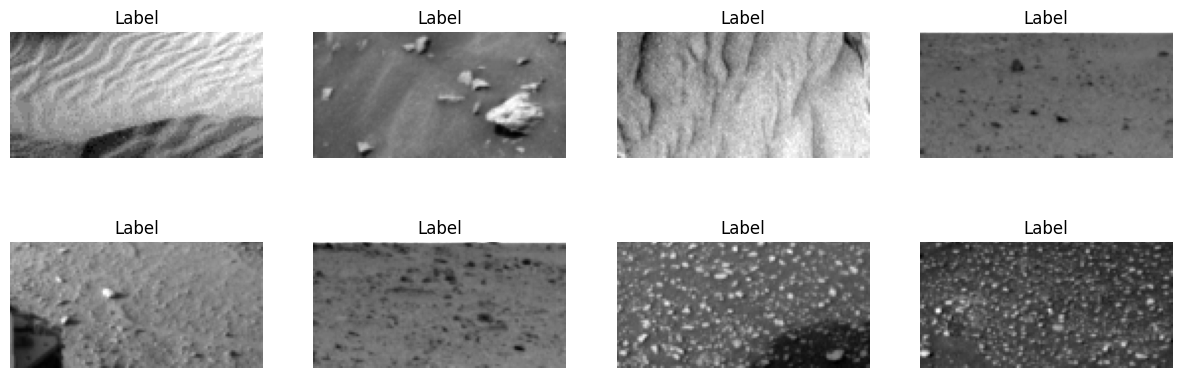

In [7]:
# Look at the augmented data
for batch_images, batch_labels in val_dataset.take(1):
    # batch_images and batch_labels are now a batch of data
    print("Batch images shape:", batch_images.shape)
    print("Batch labels shape:", batch_labels.shape)

def display_batch(batch_images, batch_labels, num_samples=8):
    # Display up to `num_samples` images and their labels
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(batch_images[i].numpy().squeeze(), cmap='gray')  # Adjust for grayscale
        plt.title("Label")
        plt.axis("off")
    plt.show()

# Display the batch
display_batch(batch_images, batch_labels)

In [8]:
# Add color channel and rescale pixels between 0 and 1
X_train = (X_train[..., np.newaxis]).astype('int32')
X_test = (X_test[..., np.newaxis]).astype('int32')
X_val = (X_val[..., np.newaxis]).astype('int32')

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [9]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [10]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = unet_block(d3, 256, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_3])
    u1 = unet_block(u1, 128, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_1])
    u3 = unet_block(u3, 32, name='up_block3_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [11]:
model = get_unet_model()
# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=False, show_trainable=False)



Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_conv1   │ (None, 64, 128,   │        320 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_bn1     │ (None, 64, 128,   │        128 │ down_block1_conv… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_activa… │ (None, 64, 128,   │          0 │ down_block1_bn1[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_conv2   │ (None, 64, 128,   │      9,248 │ down_block1_acti… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_bn2     │ (None, 64, 128,   │        128 │ down_block1_conv… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_activa… │ (None, 64, 128,   │          0 │ down_block1_bn2[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ down_block1_acti… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_conv1   │ (None, 32, 64,    │     18,496 │ max_pooling2d[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_bn1     │ (None, 32, 64,    │        256 │ down_block2_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_activa… │ (None, 32, 64,    │          0 │ down_block2_bn1[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_conv2   │ (None, 32, 64,    │     36,928 │ down_block2_acti… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_bn2     │ (None, 32, 64,    │        256 │ down_block2_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_activa… │ (None, 32, 64,    │          0 │ down_block2_bn2[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 32,    │          0 │ down_block2_acti… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block3_conv1   │ (None, 16, 32,    │     73,856 │ max_pooling2d_1[… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block3_bn1     │ (None, 16, 32,    │        512 │ down_block3_conv

 Total params: 1,952,069 (7.45 MB)

 Trainable params: 1,949,253 (7.44 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [12]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [13]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [14]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

In [15]:
# Train the model
history = model.fit(
    x=augmented_train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_pre.keras'
model.save(model_filename)

Epoch 1/1000


I0000 00:00:1733045904.024219      81 service.cc:145] XLA service 0x7c9f8c006e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733045904.024305      81 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733045904.024313      81 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1733045907.251645      81 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


 1/63 ━━━━━━━━━━━━━━━━━━━━ 26:27 26s/step - accuracy: 0.2410 - loss: 1.6844 - mean_iou: 0.0885

I0000 00:00:1733045921.038298      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2922 - loss: 1.6125 - mean_iou: 0.1243

W0000 00:00:1733045927.557550      79 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.2929 - loss: 1.6109 - mean_iou: 0.1246

W0000 00:00:1733045942.105673      82 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733045945.206426      81 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 424ms/step - accuracy: 0.2935 - loss: 1.6093 - mean_iou: 0.1250 - val_accuracy: 0.1783 - val_loss: 1.6004 - val_mean_iou: 0.0595
Epoch 2/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.4381 - loss: 1.3346 - mean_iou: 0.2120 - val_accuracy: 0.2563 - val_loss: 1.5627 - val_mean_iou: 0.0984
Epoch 3/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.4869 - loss: 1.2452 - mean_iou: 0.2454 - val_accuracy: 0.3252 - val_loss: 1.4994 - val_mean_iou: 0.1379
Epoch 4/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5335 - loss: 1.1694 - mean_iou: 0.2714 - val_accuracy: 0.4553 - val_loss: 1.2682 - val_mean_iou: 0.2409
Epoch 5/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5553 - loss: 1.1235 - mean_iou: 0.2860 - val_accuracy: 0.4428 - val_loss: 1.3326 - val_mean_iou: 0.2199
Epoch 6/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5755 - loss: 1.0749 - mean_iou: 0.3039 - val_accuracy: 0.5182 - val_loss: 1.2180 - val_me

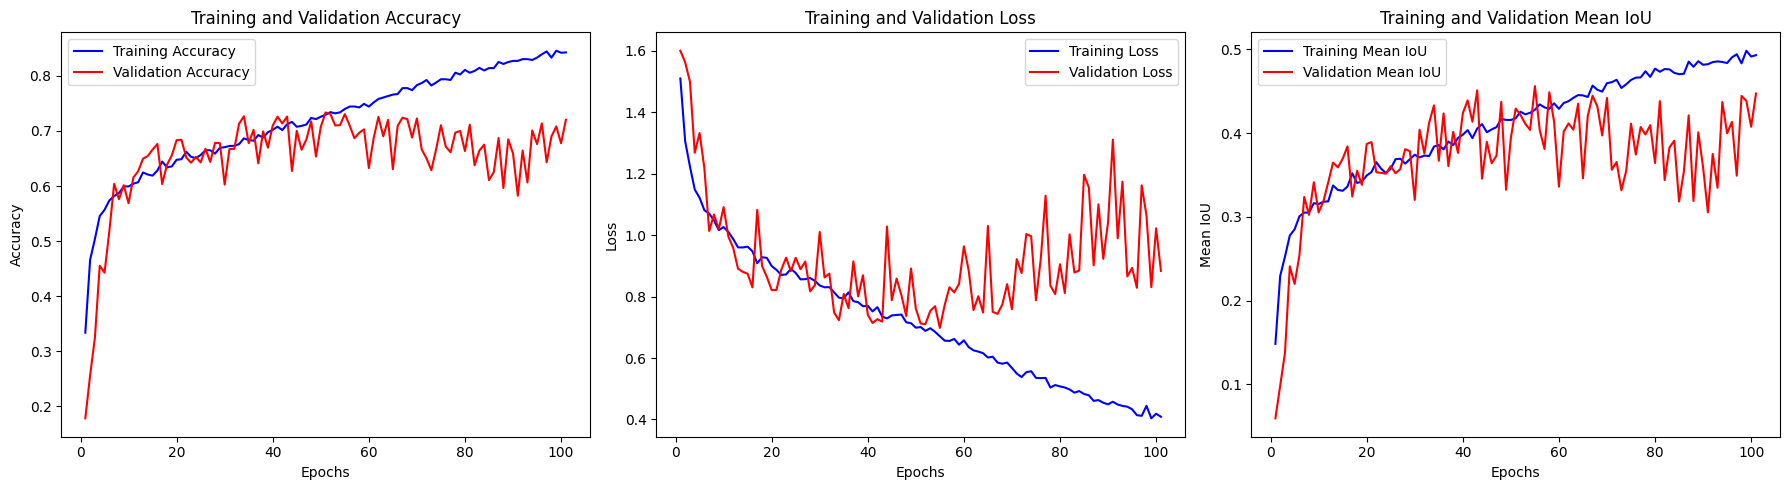

In [19]:
# Extract metrics
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
mean_iou = history['mean_iou']
val_mean_iou = history['val_mean_iou']
epochs = range(1, len(accuracy) + 1)

# Plot Accuracy
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Mean IoU
plt.subplot(1, 3, 3)
plt.plot(epochs, mean_iou, 'b-', label='Training Mean IoU')
plt.plot(epochs, val_mean_iou, 'r-', label='Validation Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [16]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step
Predictions shape: (10022, 64, 128)


In [17]:
def y_to_df(y) -> pd.DataFrame:
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [18]:
# Get the current date and time as a string
current_time = time.strftime("%Y-%m-%d_%H:%M:%S")

# Create and download the csv submission file
submission_filename = f"submission_Lecture_5b_notebook_data_V1_augmented_"+current_time+".csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)